In [1]:
import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

In [2]:
california_housing_dataframe = pd.read_csv("https://storage.googleapis.com/mledu-datasets/california_housing_train.csv", sep=",")

In [3]:
california_housing_dataframe = california_housing_dataframe.reindex(
    np.random.permutation(california_housing_dataframe.index))
california_housing_dataframe["median_house_value"] /= 1000.0
california_housing_dataframe

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
9479,-119.3,34.3,23.0,3578.0,753.0,1455.0,649.0,4.2,359.1
13651,-122.0,38.0,23.0,2293.0,411.0,969.0,399.0,4.5,184.0
13360,-121.9,37.3,29.0,1377.0,430.0,969.0,399.0,2.7,252.8
10864,-120.8,37.5,21.0,2974.0,495.0,1313.0,461.0,4.5,135.4
13207,-121.9,37.4,47.0,1007.0,245.0,581.0,240.0,3.0,237.5
...,...,...,...,...,...,...,...,...,...
9589,-119.4,36.2,18.0,1082.0,202.0,793.0,213.0,2.4,60.0
7038,-118.3,33.7,33.0,2265.0,366.0,986.0,388.0,5.5,409.8
11071,-121.0,37.6,45.0,1913.0,335.0,839.0,333.0,3.1,110.7
4243,-118.0,33.9,18.0,2628.0,720.0,2276.0,649.0,2.7,170.8


In [4]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a linear regression model of one feature.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
  
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
      ds = ds.shuffle(buffer_size=10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [5]:
def train_model(learning_rate, steps, batch_size, input_feature="total_rooms"):
    periods = 10
    steps_per_period = steps / periods
    my_feature = input_feature
    my_feature_data = california_housing_dataframe[[my_feature]]
    my_label = "median_house_value"
    targets = california_housing_dataframe[my_label]

      # Create feature columns.
    feature_columns = [tf.feature_column.numeric_column(my_feature)]

      # Create input functions.
    training_input_fn = lambda:my_input_fn(my_feature_data, targets, batch_size=batch_size)
    prediction_input_fn = lambda: my_input_fn(my_feature_data, targets, num_epochs=1, shuffle=False)

      # Create a linear regressor object.
    my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
    linear_regressor = tf.estimator.LinearRegressor(
          feature_columns=feature_columns,
          optimizer=my_optimizer
      )

      # Set up to plot the state of our model's line each period.
    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)
    plt.title("Learned Line by Period")
    plt.ylabel(my_label)
    plt.xlabel(my_feature)
    sample = california_housing_dataframe.sample(n=300)
    plt.scatter(sample[my_feature], sample[my_label])
    colors = [cm.coolwarm(x) for x in np.linspace(-1, 1, periods)]

      # Train the model, but do so inside a loop so that we can periodically assess
      # loss metrics.
    print ("Training model...")
    print ("RMSE (on training data):")
    root_mean_squared_errors = []
    for period in range (0, periods):
        # Train the model, starting from the prior state.
        linear_regressor.train(
            input_fn=training_input_fn,
            steps=steps_per_period
        )
        # Take a break and compute predictions.
        predictions = linear_regressor.predict(input_fn=prediction_input_fn)
        predictions = np.array([item['predictions'][0] for item in predictions])
        

        # Compute loss.
        root_mean_squared_error = math.sqrt(
            metrics.mean_squared_error(predictions, targets))
        # Occasionally print the current loss.
        print(period, root_mean_squared_error)
        # Add the loss metrics from this period to our list.
        root_mean_squared_errors.append(root_mean_squared_error)
        # Finally, track the weights and biases over time.
        # Apply some math to ensure that the data and line are plotted neatly.
        y_extents = np.array([0, sample[my_label].max()])
     
        weight = linear_regressor.get_variable_value('linear/linear_model/{}/weights'.format(input_feature))[0]
        bias = linear_regressor.get_variable_value('linear/linear_model/bias_weights')
       

        x_extents = (y_extents - bias) / weight
        x_extents = np.maximum(np.minimum(x_extents,
                                          sample[my_feature].max()),
                               sample[my_feature].min())
        y_extents = weight * x_extents + bias
        plt.plot(x_extents, y_extents, color=colors[period]) 
    print ("Model training finished.")

  # Output a graph of loss metrics over periods.
    plt.subplot(1, 2, 2)
    plt.ylabel('RMSE')
    plt.xlabel('Periods')
    plt.title("Root Mean Squared Error vs. Periods")
    plt.tight_layout()
    plt.plot(root_mean_squared_errors)

  # Output a table with calibration data.
    calibration_data = pd.DataFrame()
    calibration_data["predictions"] = pd.Series(predictions)
    calibration_data["targets"] = pd.Series(targets)
    display.display(calibration_data.describe())

    print (root_mean_squared_error)

Training model...
RMSE (on training data):
{'total_rooms': array([ 3578.,  2293.,  1377., ...,  1913.,  2628.,  9601.])}
{'total_rooms': array([ 3578.,  2293.,  1377., ...,  1913.,  2628.,  9601.])}
0 236.31947496332074
{'total_rooms': array([ 3578.,  2293.,  1377., ...,  1913.,  2628.,  9601.])}
{'total_rooms': array([ 3578.,  2293.,  1377., ...,  1913.,  2628.,  9601.])}
1 235.10539830467124
{'total_rooms': array([ 3578.,  2293.,  1377., ...,  1913.,  2628.,  9601.])}
{'total_rooms': array([ 3578.,  2293.,  1377., ...,  1913.,  2628.,  9601.])}
2 233.8975676238156
{'total_rooms': array([ 3578.,  2293.,  1377., ...,  1913.,  2628.,  9601.])}
{'total_rooms': array([ 3578.,  2293.,  1377., ...,  1913.,  2628.,  9601.])}
3 232.69608235549353
{'total_rooms': array([ 3578.,  2293.,  1377., ...,  1913.,  2628.,  9601.])}
{'total_rooms': array([ 3578.,  2293.,  1377., ...,  1913.,  2628.,  9601.])}
4 231.50104252202942
{'total_rooms': array([ 3578.,  2293.,  1377., ...,  1913.,  2628.,  9601

,predictions,targets
count,17000.0,17000.0
mean,13.2,207.3
std,10.9,116.0
min,0.0,15.0
25%,7.3,119.4
50%,10.6,180.4
75%,15.8,265.0
max,189.7,500.0


225.62605861000725


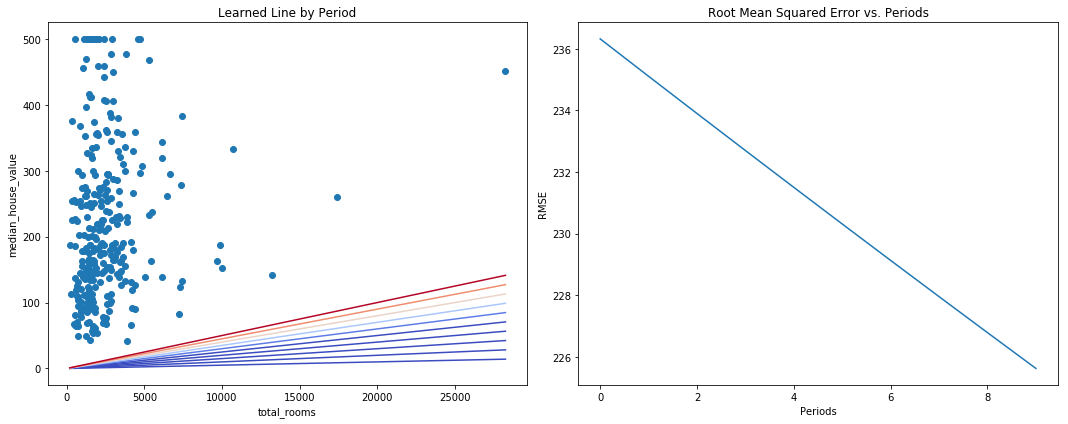

In [6]:
train_model(
    learning_rate=0.00001,
    steps=100,
    batch_size=1
)